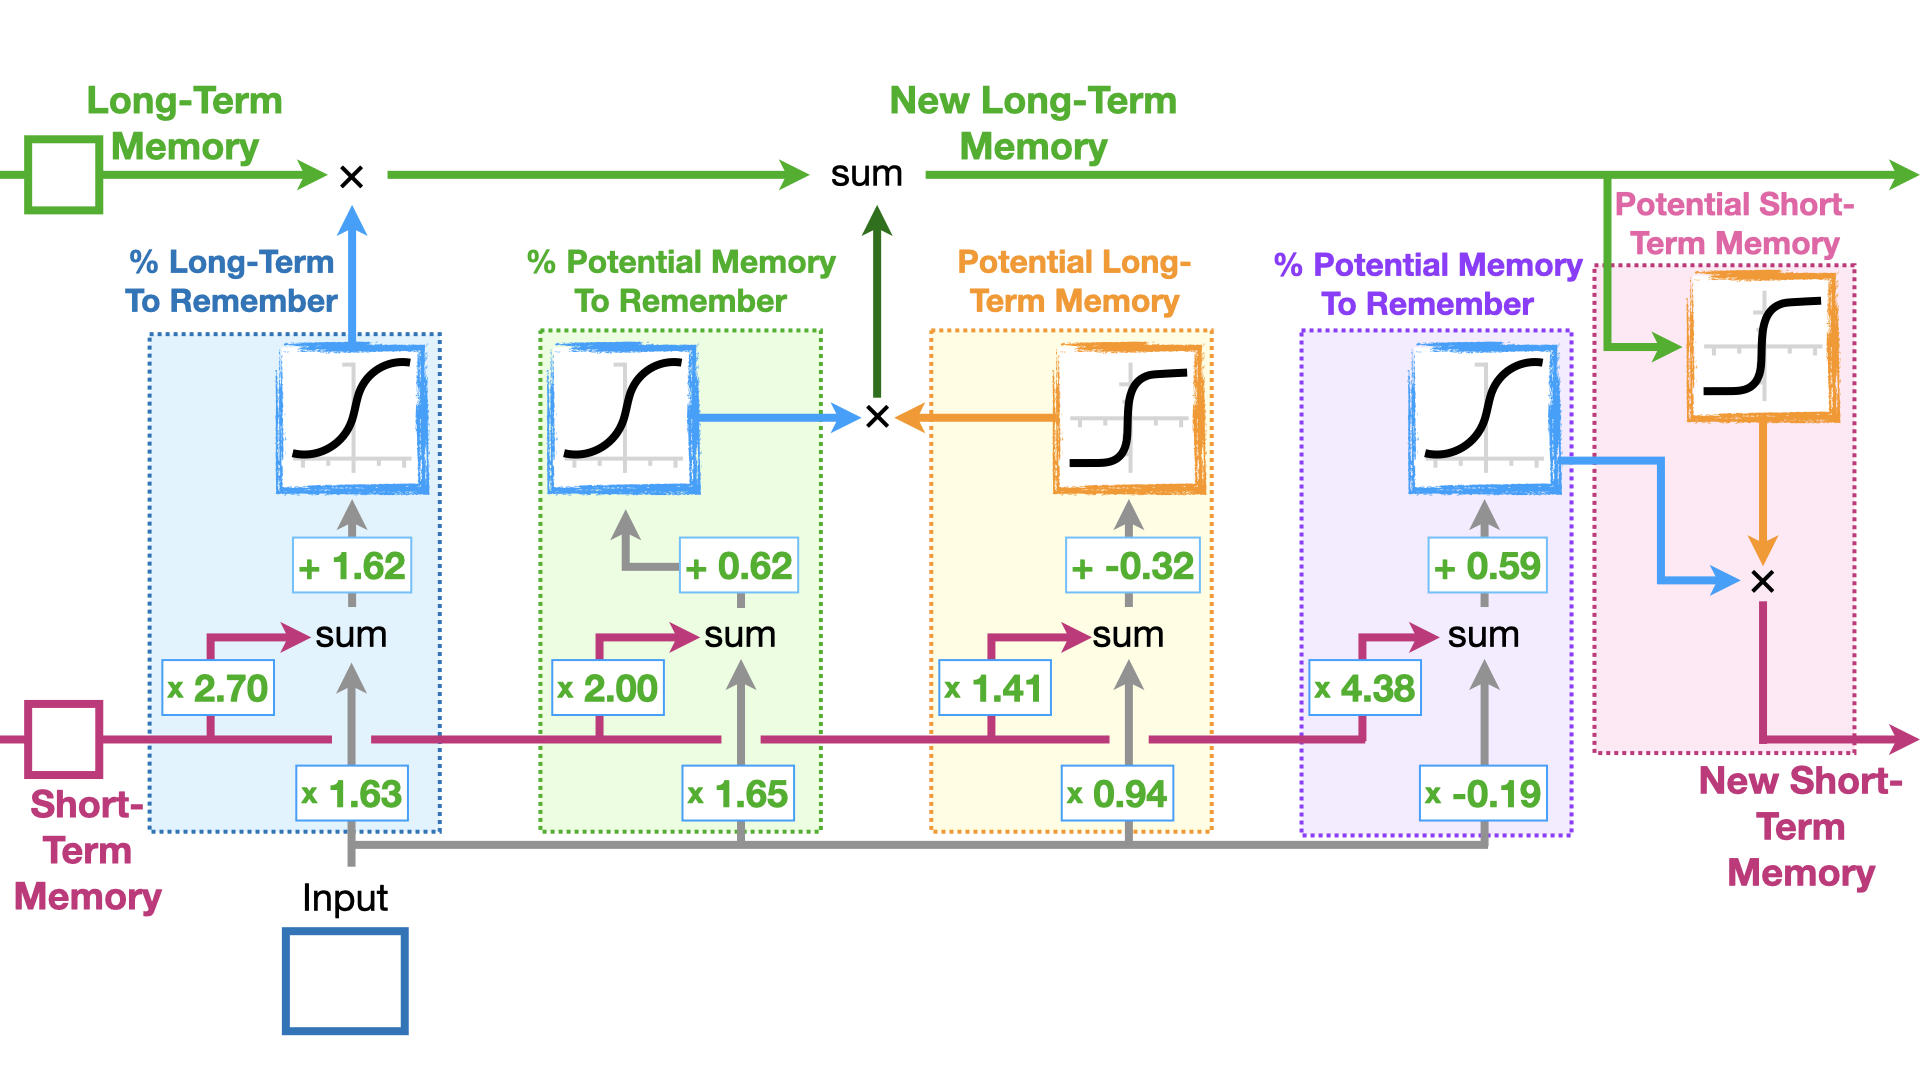

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.adam as Adam

## LSTM by Hand

In [109]:
class LSTMbyHand(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        mean = torch.tensor(0.0)
        std = torch.tensor(0.1)

        ## forget gate
        self.Wf = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Uf = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bf = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## input gate
        self.Wi = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Ui = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bi = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## State gate
        self.Ws = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Us = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bs = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        ## Output gate
        self.Wo = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, input_size)), requires_grad=True)
        self.Uo = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_size, hidden_size)), requires_grad=True)
        self.bo = nn.Parameter(torch.zeros(hidden_size), requires_grad=True)

        self.hidden_size = hidden_size

    def forward(self, input, hidden, cell_state):
        forget_gate = torch.sigmoid(torch.matmul(self.Wf, input) + torch.matmul(self.Uf, hidden) + self.bf)
        input_gate = torch.sigmoid(torch.matmul(self.Wi, input) + torch.matmul(self.Ui, hidden) + self.bi)
        state_gate = torch.tanh(torch.matmul(self.Ws, input) + torch.matmul(self.Us, hidden) + self.bs)
        output_gate = torch.sigmoid(torch.matmul(self.Wo, input) + torch.matmul(self.Uo, hidden) + self.bo)

        cell_state = forget_gate * cell_state + input_gate * state_gate
        hidden = output_gate * torch.tanh(cell_state)

        return hidden, cell_state

    def optimize(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def train_model(self, batches, max_epoch=10000):
        optimizer = self.optimize()
        
        for epoch in range(max_epoch):
            hidden = torch.zeros(self.hidden_size)
            cell_state = torch.zeros(self.hidden_size)
            
            for index in range(len(batches)):
                input = batches[index][:4].view(-1, 1)  # Extract input and reshape to (4, 1)
                target = batches[index][4].unsqueeze(0)  # Extract target value
                
                hidden, cell_state = self.forward(input, hidden, cell_state)
                loss = torch.mean((hidden - target) ** 2)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                # Detach hidden and cell state to prevent the graph from growing
                hidden = hidden.detach()
                cell_state = cell_state.detach()
                
                print(f'Epoch {epoch} Loss {loss.item()}')

    def predict(self, input):
        hidden = torch.zeros(self.hidden_size)
        cell_state = torch.zeros(self.hidden_size)
        hidden, cell_state = self.forward(input, hidden, cell_state)
        return hidden

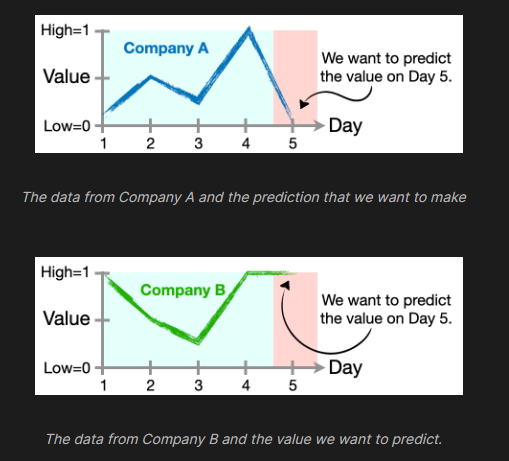

In [110]:
def dataLoader():
    batches = torch.tensor([[0.0, 0.5, 0.25, 1.0, 0.0], [1.0, 0.5, 0.25, 1.0, 1.0]])
    return batches

In [111]:
input_size = 4  
hidden_size = 1
lstm = LSTMbyHand(input_size, hidden_size)
# Load the data
batches = dataLoader()
# Train the model
lstm.train_model(batches,max_epoch=50000)


Epoch 0 Loss 0.0006389289628714323
Epoch 0 Loss 0.9703671336174011
Epoch 1 Loss 0.0006271197344176471
Epoch 1 Loss 0.9680396318435669
Epoch 2 Loss 0.00067972979741171
Epoch 2 Loss 0.9643380641937256
Epoch 3 Loss 0.0007377213332802057
Epoch 3 Loss 0.9605071544647217
Epoch 4 Loss 0.0007996716303750873
Epoch 4 Loss 0.9565992951393127
Epoch 5 Loss 0.0008651993121020496
Epoch 5 Loss 0.9526320099830627
Epoch 6 Loss 0.0009341794648207724
Epoch 6 Loss 0.9486134648323059
Epoch 7 Loss 0.0010065825190395117
Epoch 7 Loss 0.9445478916168213
Epoch 8 Loss 0.0010824211640283465
Epoch 8 Loss 0.9404370188713074
Epoch 9 Loss 0.001161729684099555
Epoch 9 Loss 0.9362821578979492
Epoch 10 Loss 0.001244555925950408
Epoch 10 Loss 0.932083785533905
Epoch 11 Loss 0.001330954721197486
Epoch 11 Loss 0.9278421401977539
Epoch 12 Loss 0.0014209859073162079
Epoch 12 Loss 0.9235571622848511
Epoch 13 Loss 0.0015147122321650386
Epoch 13 Loss 0.9192290306091309
Epoch 14 Loss 0.0016121981898322701
Epoch 14 Loss 0.91485732

In [112]:
round(lstm.predict(torch.tensor([0.0, 0.5, 0.25, 1.0]))[0].item(),3)

-0.0

In [113]:
round(lstm.predict(torch.tensor([1.0, 0.5, 0.25, 1.0]))[0].item(),3)

0.762